Start with something simple, 1D, and only slightly nongaussian.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

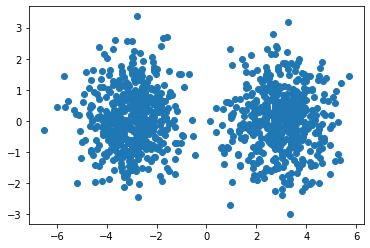

In [3]:
# Sample from the initial distribution
X1 = np.random.normal(-3, 1, 500) 
X2 = np.random.normal(3, 1, 500)  
Y  = np.random.normal(0,1,1000)

X = np.concatenate([X1 ,X2])

plt.scatter(X,Y)


The example here is just going to be two 2d gaussians. Now to set up the MADE.


In [4]:
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10,10]) # not sure what hidden units are 

# Define the target distribution
distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
data = np.stack([X, Y], axis=-1)

batch_size = 25
model.fit(x=data,
          y=np.zeros((1000, 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=10,
          steps_per_epoch=20,  # Usually `n // batch_size`.
          shuffle=True,
          verbose=True)


Epoch 1/10


2022-03-15 17:25:51.770703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 17:25:51.789038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 17:25:51.789163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 17:25:51.789576: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

20/20 [==============================] - 0s 1ms/step - loss: 8.5293
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 7.1357
Epoch 3/10
20/20 [==============================] - 0s 1ms/step - loss: 6.7323
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 6.9027
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 6.6091
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 6.4131
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 6.3489
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 6.1688
Epoch 9/10
20/20 [==============================] - 0s 1ms/step - loss: 6.0201
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 6.0556


(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  2.,  0.,  1.,  1.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  1.,  5.,  3.,  1.,  3.,  1.,  2.,  1.,
          0.,  0.],
        [ 0.,  1.,  1.,  3.,  2.,  3.,  6.,  5.,  6.,  6.,  3.,  3.,  2.,
          2.,  0.],
        [ 1.,  0.,  2.,  0.,  8.,  5., 17., 18., 10.,  7.,  9.,  4.,  0.,
          2.,  1.],
        [ 0.,  0.,  2.,  3., 11., 17., 27., 19., 22., 15.,  6.,  6.,  5.,
          2.,  2.],
        [ 2.,  0.,  1.,  4., 13., 17., 28., 28., 24., 18.,  8., 12.,  6.,
          5.,  0.],
        [ 1.,  1.,  3.,  5.,  8., 17., 19., 28., 32., 19., 14., 12.,  6.,
          2.,  0.],
        [ 0.,  2.,  1.,  3., 11., 11., 20., 31., 26., 17., 11.,  3.,  7.,
          2.,  0.],
        [ 0.,  1.,  3.,  0.,  7.,  9., 17., 17., 14., 18., 10.,  6.,  3.,
          2.,  1.],
        [ 0.,  0.,  0.,  3.,  9., 10., 11., 10., 10.,  9.,  

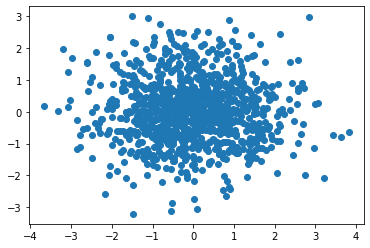

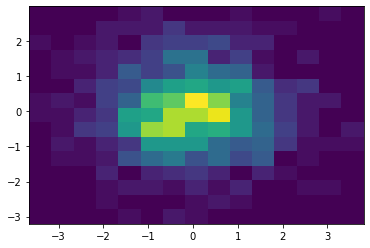

In [5]:
# Use the fitted distribution.
s=1000
samples = distribution.sample(s)
#distribution.log_prob(np.ones((3, 2), dtype=np.float32))
#print(samples)

x,y=[],[]

for i in range(0,s):
    x.append(float(samples[i][0]))
    y.append(float(samples[i][1]))

fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
ax1.scatter(x,y)
ax2.hist2d(x,y,bins=[15,15])

Looks pretty Gausian! Now lets apply a fit, determine the full gaussian map, and plot some contours.

(array([[  0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   1.,   8.,   9.,   5.,   4.,   0.,   0.],
        [  1.,   2.,   6.,  27.,  25.,  20.,  10.,   3.,   0.],
        [  0.,   2.,  21.,  67.,  80.,  44.,  21.,   6.,   0.],
        [  0.,   2.,  22.,  64., 113.,  66.,  29.,   5.,   0.],
        [  0.,   4.,  10.,  48.,  77.,  55.,  19.,   3.,   0.],
        [  0.,   0.,   6.,  34.,  29.,  18.,   4.,   2.,   0.],
        [  0.,   0.,   2.,   3.,   8.,   5.,   2.,   1.,   0.],
        [  0.,   0.,   1.,   3.,   0.,   0.,   0.,   0.,   0.]]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 <matplotlib.collections.QuadMesh at 0x7f4f3046c3a0>)

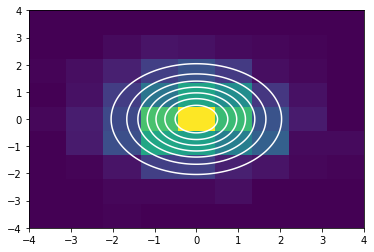

In [6]:
from scipy.stats import multivariate_normal

dist_x, dist_y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((dist_x, dist_y))
rv = multivariate_normal([0., 0.], [[1.0, 0.], [0., 1.0]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contour(dist_x, dist_y, rv.pdf(pos),colors='w')
ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])

In [15]:
print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[0])
results = np.stack(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[0])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[1])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[2])
binx=[]
biny=[]
edge_x = ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[1]
edge_y = ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[2]

for i in range(len(edge_x)-1):
    binx.append((edge_x[i+1]-edge_x[i])/2 + edge_x[i])
for i in range(len(edge_y)-1):
    biny.append((edge_y[i+1]-edge_y[i])/2 + edge_y[i])

bins=[]
z=[]
#bins.append(binx)
#bins.append(biny)
xvals = []
yvals = []

for i in range(len(binx)-1):
    for j in range(len(biny)-1):
        xvals.append(binx[i])
        yvals.append(biny[j])
        z.append(results[i][j])
        
print(xvals)
print(yvals)
print(z)

[[  0.   0.   0.   0.   2.   0.   1.   0.   0.]
 [  0.   0.   1.   8.   9.   5.   4.   0.   0.]
 [  1.   2.   6.  27.  25.  20.  10.   3.   0.]
 [  0.   2.  21.  67.  80.  44.  21.   6.   0.]
 [  0.   2.  22.  64. 113.  66.  29.   5.   0.]
 [  0.   4.  10.  48.  77.  55.  19.   3.   0.]
 [  0.   0.   6.  34.  29.  18.   4.   2.   0.]
 [  0.   0.   2.   3.   8.   5.   2.   1.   0.]
 [  0.   0.   1.   3.   0.   0.   0.   0.   0.]]
[-3.5555555555555554, -3.5555555555555554, -3.5555555555555554, -3.5555555555555554, -3.5555555555555554, -3.5555555555555554, -3.5555555555555554, -3.5555555555555554, -2.666666666666667, -2.666666666666667, -2.666666666666667, -2.666666666666667, -2.666666666666667, -2.666666666666667, -2.666666666666667, -2.666666666666667, -1.777777777777778, -1.777777777777778, -1.777777777777778, -1.777777777777778, -1.777777777777778, -1.777777777777778, -1.777777777777778, -1.777777777777778, -0.8888888888888891, -0.8888888888888891, -0.8888888888888891, -0.888888888888

In [18]:
# Thanks https://stackoverflow.com/questions/52148141/2d-gaussian-fit-using-lmfit 
# since it has been so long since I used lmfit
from lmfit import Parameters, minimize, report_fit

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0)

def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    sigma_y = p["sigma_y"].value
    return (z - height*gaussian2D(x,y, cen_x, cen_y, sigma_x, sigma_y))

initial = Parameters()
initial.add("height",value=1.)
initial.add("centroid_x",value=0.)
initial.add("centroid_y",value=0.)
initial.add("sigma_x",value=1.)
initial.add("sigma_y",value=1.)

fit = minimize(residuals, initial, args=(xvals,yvals, z))
print(report_fit(fit))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 64
    # variables        = 5
    chi-square         = 897.513698
    reduced chi-square = 15.2120966
    Akaike info crit   = 179.007699
    Bayesian info crit = 189.802115
[[Variables]]
    height:      105.223373 +/- 2.55223731 (2.43%) (init = 1)
    centroid_x: -0.02142289 +/- 0.02798811 (130.65%) (init = 0)
    centroid_y: -0.01755406 +/- 0.02470240 (140.72%) (init = 0)
    sigma_x:     1.15395678 +/- 0.02804911 (2.43%) (init = 1)
    sigma_y:     1.01868629 +/- 0.02469162 (2.42%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(height, sigma_x) = -0.501
    C(height, sigma_y) = -0.500
None


(array([[  0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   1.,   8.,   9.,   5.,   4.,   0.,   0.],
        [  1.,   2.,   6.,  27.,  25.,  20.,  10.,   3.,   0.],
        [  0.,   2.,  21.,  67.,  80.,  44.,  21.,   6.,   0.],
        [  0.,   2.,  22.,  64., 113.,  66.,  29.,   5.,   0.],
        [  0.,   4.,  10.,  48.,  77.,  55.,  19.,   3.,   0.],
        [  0.,   0.,   6.,  34.,  29.,  18.,   4.,   2.,   0.],
        [  0.,   0.,   2.,   3.,   8.,   5.,   2.,   1.,   0.],
        [  0.,   0.,   1.,   3.,   0.,   0.,   0.,   0.,   0.]]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 <matplotlib.collections.QuadMesh at 0x7f4c1a5ed990>)

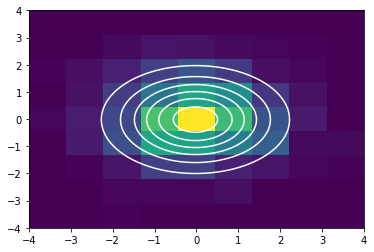

In [52]:
X = np.linspace(-4,4,100)
Y = np.linspace(-4,4,100)
X,Y = np.meshgrid(X, Y)

xo = fit.params["centroid_x"].value
yo = fit.params["centroid_y"].value
sx = fit.params["sigma_x"].value
sy = fit.params["sigma_y"].value

Z=gaussian2D(X,Y,xo,yo,sx,sy)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contour(X, Y, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])